# Rune Recognition

In association with [Astraeus-](https://github.com/Astraeus-)

## Packages we need

List of packages we need

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

import os
from skimage import io # for reading images

from sklearn.model_selection import train_test_split # for splitting data into training and validation sets

# for plotting confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

## Read in the dataset

First, we read all images from the `MLBD-IML-2023-Anglo-Saxon-Runes` folder. We do this using Scikit-Image. In total we have 1471 images with 12 labels. We infer the labels from the filename.

In [2]:
directory = "./MLBD-IML-2023-Anglo-Saxon-Runes/" # Path to the dataset
images = [] # List of images

for filename in os.listdir(directory):
    # Check if the file is an image
    if filename.endswith(".png"):
        label = filename.split("_")[0].lower() # Get the label
        # Label and load the image
        img = io.imread(os.path.join(directory, filename))
        images.append((img, label))

# Print the number of images
print("Number of images: " + str(len(images)))
print("All labels: " + str(set([label for _, label in images])))

Number of images: 1471
All labels: {'ash', 'joy', 'oak', 'need', 'wealth', 'gift', 'sun', 'elk-sedge', 'spear', 'tyr', 'bow', 'serpent'}


### Create DataFrame

We create a DataFrame from the raw images and labels. We do this by storing the images as a list of lists, where each sublist contains the pixels of an image. With a DataFrame we can easily work with the data later on.

In [3]:
df = pd.DataFrame(images, columns=['image', 'label'])

df

,image,label
0,"[[[255, 255, 255, 255], [255, 255, 255, 255], ...",joy
1,"[[[255, 255, 255, 255], [255, 255, 255, 255], ...",joy
2,"[[[255, 255, 255, 255], [255, 255, 255, 255], ...",ash
3,"[[[255, 255, 255, 255], [255, 255, 255, 255], ...",spear
4,"[[[255, 255, 255, 255], [255, 255, 255, 255], ...",gift
...,...,...
1466,"[[[255, 255, 255, 255], [255, 255, 255, 255], ...",spear
1467,"[[[255, 255, 255, 255], [255, 255, 255, 255], ...",tyr
1468,"[[[255, 255, 255, 255], [255, 255, 255, 255], ...",tyr
1469,"[[[255, 255, 255, 255], [255, 255, 255, 255], ...",bow


## Preprocess the data

Since we have 12 labels, we must one-hot encode the labels. This way all labels will be a 0 or 1 (true/false) value and the neural network can learn the labels. We also create a custom label encored to convert the `y` (string) labels to numbers.

We will not do any more preprocessing before the model itself. We do not remove any junk data and we do not normalize the data.This way we can experiment with neural networks when we provide them raw image data.

We will do basic image preprocessing in the model itself.

In [4]:
labels = pd.get_dummies(df['label'])
df_encoded = pd.concat([df, labels], axis=1)

label_encoder = {'ash': 0, 'bow': 1, 'elk-sedge': 2, 'gift': 3, 'joy': 4, 'need': 5, 'oak': 6, 'serpent': 7, 'spear': 8, 'sun': 9, 'tyr': 10, 'wealth': 11}

df_encoded['label'] = df_encoded['label'].map(label_encoder)

df_encoded

,image,label,ash,bow,elk-sedge,gift,joy,need,oak,serpent,spear,sun,tyr,wealth
0,"[[[255, 255, 255, 255], [255, 255, 255, 255], ...",4,False,False,False,False,True,False,False,False,False,False,False,False
1,"[[[255, 255, 255, 255], [255, 255, 255, 255], ...",4,False,False,False,False,True,False,False,False,False,False,False,False
2,"[[[255, 255, 255, 255], [255, 255, 255, 255], ...",0,True,False,False,False,False,False,False,False,False,False,False,False
3,"[[[255, 255, 255, 255], [255, 255, 255, 255], ...",8,False,False,False,False,False,False,False,False,True,False,False,False
4,"[[[255, 255, 255, 255], [255, 255, 255, 255], ...",3,False,False,False,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1466,"[[[255, 255, 255, 255], [255, 255, 255, 255], ...",8,False,False,False,False,False,False,False,False,True,False,False,False
1467,"[[[255, 255, 255, 255], [255, 255, 255, 255], ...",10,False,False,False,False,False,False,False,False,False,False,True,False
1468,"[[[255, 255, 255, 255], [255, 255, 255, 255], ...",10,False,False,False,False,False,False,False,False,False,False,True,False
1469,"[[[255, 255, 255, 255], [255, 255, 255, 255], ...",1,False,True,False,False,False,False,False,False,False,False,False,False


## Create training and testing datasets

First, we create separate variables for the data `X` and for the labels `y`. We one-hot encode the labels, so that we can use them in our neural network, since one-hot encoding makes it easier for the neural network to learn the labels.

We have to encode the image data to float32, since this is the datatype that TensorFlow expects when working with array multiplication.

We split our data into 10% testing data and 90% training data. We have a lot of data, so we can afford to use 20% of our data for testing. Before in poker cards, we used 10%, but now we have way less data, so we increase the test size so we have more samples in there. We use the random state of `42` to make sure that we always get the same split.

We also give `y` to stratify, so that we get the same distribution of labels in our training and testing data. This is important, because we have a very unbalanced dataset.

In [5]:
X = df_encoded.drop('label', axis=1) # values
y = df_encoded['label'] # labels
X = np.array([x for x in X['image']]).astype(np.float32)

y_one_hot = tf.keras.utils.to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size = 0.2, random_state = 42, stratify=y)

## Models

For our convolutional neural network we create a class that acts as a wrapper for the model. This way we can easily create multiple models with different configurations and compare them.

We use the same model structure we used before in the previous assignment (Assignment 2.1).

For out model, we use the following base defaults:

- Adam optimizer with a learning rate of 3e-4 (as suggested by [Andrej Karpathy](https://karpathy.ai) in a [tweet](https://twitter.com/karpathy/status/801621764144971776?ref_src=twsrc%5Etfw%7Ctwcamp%5Etweetembed%7Ctwterm%5E801621764144971776%7Ctwgr%5E%7Ctwcon%5Es1_&ref_url=https%3A%2F%2Fbrandonlmorris.github.io%2F2018%2F06%2F24%2Fmastering-the-learning-rate%2F))
- No regularization
- An input layer with the shape of the input data
- We se softmax as our activation function for our output layer because we have a multi-class classification problem
- We use categorical crossentropy as our loss function as we have a multi-class classification problem
- For our metrics we use accuracy.
- We train our model using a batch size of 32 (the default)
- We use validation split of 0.2 to hold back 20% of our training data for validation

We altered our model from the poker cards assignment with the following changes:

- We added image data preprocessing using center crop and rescaling
- Our input layer is now one or multiple 2D convolutional layers
- We offer an option for 2D max pooling
- We flatten our data before the dense layers

For all of our models, we will keep the same following settings, so that we can compare the models with each other in a consistent way:
- We will train our models for 10 epochs as we have noticed during initial testing that the models start to flatten in accuracy and overfit after 10 epochs
- We use an early stopping of 2 epochs to prevent overfitting based on our epoch scale

### Image Preprocessing

Keras offers the following image preprocessing options:

- Center crop
- Rescaling
- Resizing

We not need to resize our images, as they are all already of the same size. We crop our image to 110 from 128. This way we get rid of some empty white pixels since most of the images are almost always in the center area, smaller than the full image size. Since our pixels are from 0 to 255, and neural networks work best with numbers between 0 and 1, we rescale our data by dividing it by 255. We offer this as an option, so that we can experiment with and without image preprocessing.

In [2]:
class NeuralNetwork:
    def __init__(self, layer_config, convolutional_layers, name, optimizer=tf.optimizers.legacy.Adam(learning_rate=3e-4), regularizer=None, image_preprocessing=True, random_rotation=False, model=None):
        self.layer_config = layer_config # list of dense layers
        self.root_logdir = "logs/as2/models/" # root directory for TensorBoard logs
        self.root_modeldir = "models/as2/" # root directory for saving models
        self.convolutional_layers = convolutional_layers # list of convolutional layers
        self.model_name = name # name of the model for saving
        self.model = model # the model itself
        self.random_rotation = random_rotation # whether to use random rotation
        self.optimizer = optimizer
        self.regularizer = regularizer
        self.image_preprocessing = image_preprocessing
    
    def compile(self):
        model = tf.keras.models.Sequential()

        if self.random_rotation: # random rotation of 45 degrees to the left and right ±0.03 which is approximately 10 degrees
            model.add(tf.keras.layers.experimental.preprocessing.RandomRotation(factor=(0.03)))

        # data preprocessing
        if self.image_preprocessing:
            model.add(tf.keras.layers.experimental.preprocessing.CenterCrop(height=110, width=110))
            model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1.0 / 255))

        for c in self.convolutional_layers:
            model.add(tf.keras.layers.Conv2D( # convolutional layers
                filters=c['filter_size'],
                kernel_size=c['kernel'],
                activation=c['activation']
            ))
            if 'max_pooling_2d_pool' and 'max_pooling_2d_strides' and 'max_pooling_2d_padding' in c: # max pooling layer if specified
                model.add(tf.keras.layers.MaxPooling2D(
                    pool_size=c['max_pooling_2d_pool'],
                    strides=c['max_pooling_2d_strides'],
                    padding=c['max_pooling_2d_padding']
                ))
        model.add(tf.keras.layers.Flatten()) # flatten layer for dense layers
        for l in self.layer_config:
            model.add(tf.keras.layers.Dense( # hidden layers
                units=l['size'],
                activation=l['activation'], 
                use_bias=l['use_bias'],
                kernel_regularizer=self.regularizer,
                bias_regularizer=self.regularizer,
                activity_regularizer=self.regularizer
            ))
            if 'batch_norm' in l and l['batch_norm']: # batch normalization layer if specified
                model.add(tf.keras.layers.BatchNormalization())
            if 'dropout' in l: # dropout layer if specified
                model.add(tf.keras.layers.Dropout(l['dropout']))
        model.add(tf.keras.layers.Dense(len(label_encoder), activation='softmax')) # output layer

        model.compile(
            optimizer=self.optimizer, # give the optimizer
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        self.model = model # save the model
    
    def fit(self, X_train, y_train, X_test, y_test, epochs=10, validation_split=0.2, verbose=0, early_stopping_patience=None):
        print(f"Training {self.model_name}...")
        if self.model is None:
            self.compile() # compile the model if not compiled yet
        
        logdir = self.root_logdir + "temp/" + datetime.now().strftime("%Y%m%d-%H%M%S") # create a log directory for TensorBoard
        
        callbacks = [tf.keras.callbacks.TensorBoard(log_dir=logdir)] # create a TensorBoard callback

        # Add EarlyStopping callback if early_stopping_patience is specified
        if early_stopping_patience:
            early_stopping = tf.keras.callbacks.EarlyStopping(
                monitor='accuracy', # monitor accuracy
                patience=early_stopping_patience,
                restore_best_weights=True
            )
            callbacks.append(early_stopping)

        history = self.model.fit(
            X_train, y_train,
            epochs=epochs,
            callbacks=callbacks,
            validation_split=validation_split,
            validation_data=(X_test, y_test), # use test set as validation set
            verbose=verbose,
            # batch_size=256 * 2
        )

        # save model
        self.model.save(self.root_modeldir + self.model_name + '.keras')
        # save history
        df_history = pd.DataFrame(history.history)
        df_history.to_csv(self.root_logdir + self.model_name + '.csv')
        print(f"Training {self.model_name} complete.")

    def evaluate(self, X_test, y_test, X_train, y_train):
        # load model
        self.model = tf.keras.models.load_model(self.root_modeldir + self.model_name + '.keras')
        test_loss, test_accuracy = self.model.evaluate(X_test, y_test, verbose=0)
        train_loss, train_accuracy = self.model.evaluate(X_train, y_train, verbose=0)

        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy * 100:.2f}%")

        # read history
        history = pd.read_csv(self.root_logdir + self.model_name + '.csv')

        # Plot training and test history in a single chart with subplots
        plt.figure(figsize=(12, 6))

        # Plot Training Accuracy
        plt.subplot(1, 2, 1)
        plt.plot(history['accuracy'], label='Training Accuracy', color='orange')
        plt.plot(history['val_accuracy'], label='Test Accuracy', color='green')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend(loc='lower right')
        plt.title('Training and Test Accuracy over Epochs')

        # Plot Training Loss
        plt.subplot(1, 2, 2)
        plt.plot(history['loss'], label='Training Loss', color='orange')
        plt.plot(history['val_loss'], label='Test Loss', color='green')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend(loc='upper right')
        plt.title('Training and Test Loss over Epochs')

        # Title and Show
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

        cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(self.model.predict(X_test, verbose=0), axis=1))
        ConfusionMatrixDisplay(cm, display_labels=label_encoder.values()).plot(cmap=plt.cm.Blues) 
        
    def predict(self, directory):
        """
        This function takes a file path to a CSV file containing test poker hands and prints the prediction accuracy
        """
        images = []
        for filename in os.listdir(directory):
            # Check if the file is an image
            if filename.endswith(".png"):
                label = filename.split("_")[0].lower() # Get the label
                # Label and load the image
                img = io.imread(os.path.join(directory, filename))
                images.append((img, label))
        df = pd.DataFrame(images, columns=['image', 'label'])
        labels = pd.get_dummies(df['label'])
        df_encoded = pd.concat([df, labels], axis=1)
        label_encoder = {'ash': 0, 'bow': 1, 'elk-sedge': 2, 'gift': 3, 'joy': 4, 'need': 5, 'oak': 6, 'serpent': 7, 'spear': 8, 'sun': 9, 'tyr': 10, 'wealth': 11}
        df_encoded['label'] = df_encoded['label'].map(label_encoder)
        X = df_encoded.drop('label', axis=1) # values
        y = df_encoded['label'] # labels
        X = np.array([x for x in X['image']]).astype(np.float32)
        y_one_hot = tf.keras.utils.to_categorical(y)
        test_loss, test_accuracy = self.model.evaluate(X, y_one_hot, verbose=0)
        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%")

### 1. First model - Initial Model

For our initial model, we decided to make a small model with the minimum required 2 convolutional layers and at least one layer. We set the neuron sizes small as we don't have many training data and we don't want to overfit.

For our initial model, we use the following baseline:

- 2 convolutional layers
- 8 neurons per convolutional layer
- Kernel size of 3x3 for each layer
- ReLU activation function for each layer
- Pooling enabled with a pool size of 2x2, stride of `None` and padding of `valid`
- Adam optimizer with a learning rate of 3e-4
- Using dropout
- Using Bias
- Using Batch Normalization
- No regularization
- Image preprocessing enabled

We use a big dropout, 50%, by default, as our model overfits way too easily.

In [7]:
convolutional_layers_1 = [
    {'filter_size': 8, 'kernel': (3,3), 'activation': 'relu', 'max_pooling_2d_pool': (2,2), 'max_pooling_2d_strides': None, 'max_pooling_2d_padding': 'valid'},
    {'filter_size': 8, 'kernel': (3,3), 'activation': 'relu', 'max_pooling_2d_pool': (2,2), 'max_pooling_2d_strides': None, 'max_pooling_2d_padding': 'valid'},
]

layers_1 = [
    {'activation': 'relu', 'size': 16, 'use_bias': True, 'dropout': 0.5, 'batch_norm': True},
]

model_1 = NeuralNetwork(layers_1, convolutional_layers_1, 'model_1')

In [8]:
model_1.fit(X_train, y_train, X_test, y_test, epochs=10, early_stopping_patience=2, verbose=1)

Training model_1...
Epoch 1/10
37/37 [==============================] - 1s 25ms/step - loss: 2.3886 - accuracy: 0.2109 - val_loss: 2.6049 - val_accuracy: 0.1763
Epoch 2/10
37/37 [==============================] - 1s 18ms/step - loss: 1.8338 - accuracy: 0.3963 - val_loss: 2.0375 - val_accuracy: 0.4068
Epoch 3/10
37/37 [==============================] - 1s 18ms/step - loss: 1.7258 - accuracy: 0.4464 - val_loss: 1.8676 - val_accuracy: 0.5661
Epoch 4/10
37/37 [==============================] - 1s 19ms/step - loss: 1.6343 - accuracy: 0.4728 - val_loss: 1.8127 - val_accuracy: 0.5627
Epoch 5/10
37/37 [==============================] - 1s 18ms/step - loss: 1.5760 - accuracy: 0.4966 - val_loss: 1.7672 - val_accuracy: 0.5424
Epoch 6/10
37/37 [==============================] - 1s 18ms/step - loss: 1.5139 - accuracy: 0.5374 - val_loss: 1.6267 - val_accuracy: 0.6373
Epoch 7/10
37/37 [==============================] - 1s 18ms/step - loss: 1.4852 - accuracy: 0.5519 - val_loss: 1.5566 - val_accuracy: 

#### Evaluation

From the results, we can see that even with such few epochs, and such a small model, we already get a very high score of 61% accuracy for testing and 70% accuracy for training. The accuracy difference between training and testing indicates that there is a bit of overfitting going on (as shown by the 9% accuracy diff). The slope of the training and testing across the epoch are stable with not a lot of fluctuation, which indicates that the model is stable and not overfitting too much.

As we can see from the graphs, our model starts to flatten already at epoch 2.


When we look at the confusion matrix, we can see that the model misclassifies a lot of the runes to label 0 and 1. Some labels also got often misclassified to label 11. All in all, we can see that we have a lot of true positives.

Test Loss: 1.5655, Test Accuracy: 61.02%
Train Loss: 1.3531, Train Accuracy: 70.41%


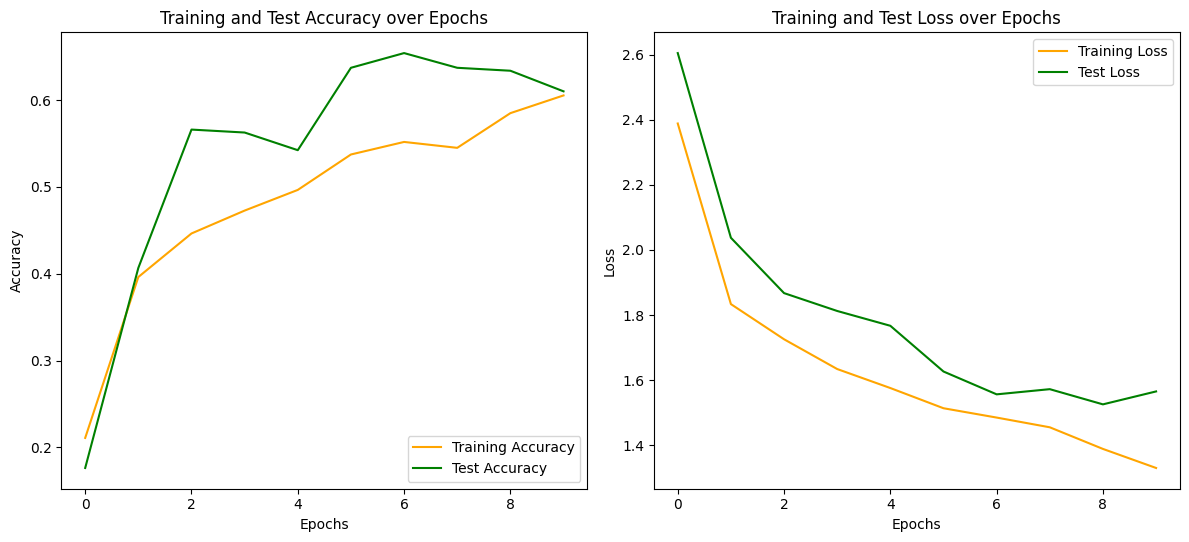

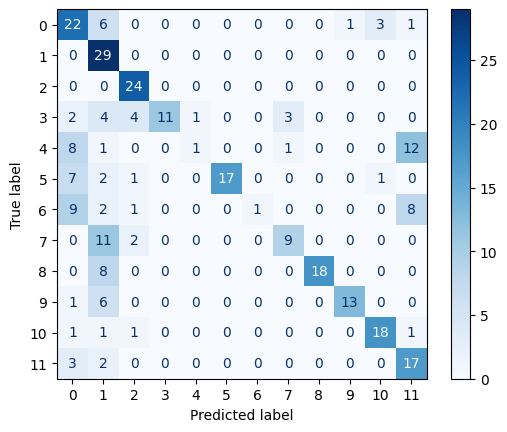

In [9]:
model_1.evaluate(X_test, y_test, X_train, y_train)

### 2. Second model - Double Convolutional Layers

Now we want to see how much does a convolutional layer help. We will double the amount of convolutional layers and see how the model performs. We keep the neuron sizes and other configurations the same as in the initial model.

Changes made compared to the initial model:

- `conv layers`: from 2 to 4

In [10]:
convolutional_layers_2 = [
    {'filter_size': 8, 'kernel': (3,3), 'activation': 'relu', 'max_pooling_2d_pool': (2,2), 'max_pooling_2d_strides': None, 'max_pooling_2d_padding': 'valid'},
    {'filter_size': 8, 'kernel': (3,3), 'activation': 'relu', 'max_pooling_2d_pool': (2,2), 'max_pooling_2d_strides': None, 'max_pooling_2d_padding': 'valid'},
    {'filter_size': 8, 'kernel': (3,3), 'activation': 'relu', 'max_pooling_2d_pool': (2,2), 'max_pooling_2d_strides': None, 'max_pooling_2d_padding': 'valid'},
    {'filter_size': 8, 'kernel': (3,3), 'activation': 'relu', 'max_pooling_2d_pool': (2,2), 'max_pooling_2d_strides': None, 'max_pooling_2d_padding': 'valid'},
]

layers_2 = [
    {'activation': 'relu', 'size': 16, 'use_bias': True, 'dropout': 0.5, 'batch_norm': True},
]

model_2 = NeuralNetwork(layers_2, convolutional_layers_2, 'model_2')

In [11]:
model_2.fit(X_train, y_train, X_test, y_test, epochs=10, early_stopping_patience=2, verbose=1)

Training model_2...
Epoch 1/10
37/37 [==============================] - 1s 26ms/step - loss: 2.5473 - accuracy: 0.1012 - val_loss: 2.4817 - val_accuracy: 0.0949
Epoch 2/10
37/37 [==============================] - 1s 21ms/step - loss: 2.4203 - accuracy: 0.1463 - val_loss: 2.4754 - val_accuracy: 0.1424
Epoch 3/10
37/37 [==============================] - 1s 21ms/step - loss: 2.3424 - accuracy: 0.1718 - val_loss: 2.4630 - val_accuracy: 0.1864
Epoch 4/10
37/37 [==============================] - 1s 21ms/step - loss: 2.2681 - accuracy: 0.2032 - val_loss: 2.4441 - val_accuracy: 0.2373
Epoch 5/10
37/37 [==============================] - 1s 22ms/step - loss: 2.1880 - accuracy: 0.2245 - val_loss: 2.4158 - val_accuracy: 0.3288
Epoch 6/10
37/37 [==============================] - 1s 21ms/step - loss: 2.1403 - accuracy: 0.2398 - val_loss: 2.3765 - val_accuracy: 0.3424
Epoch 7/10
37/37 [==============================] - 1s 22ms/step - loss: 2.0246 - accuracy: 0.2874 - val_loss: 2.3081 - val_accuracy: 

#### Evaluation

We can observe an overall accuracy loss both for testing and training. The accuracy difference between training and testing remains the same (about 9%), however the over accuracy dropped. This indicates that having more convolutional layers does not help our model.

From the confusion matrix we can also see a lot more scattered false positives.

Test Loss: 1.9973, Test Accuracy: 57.97%
Train Loss: 1.9395, Train Accuracy: 63.95%


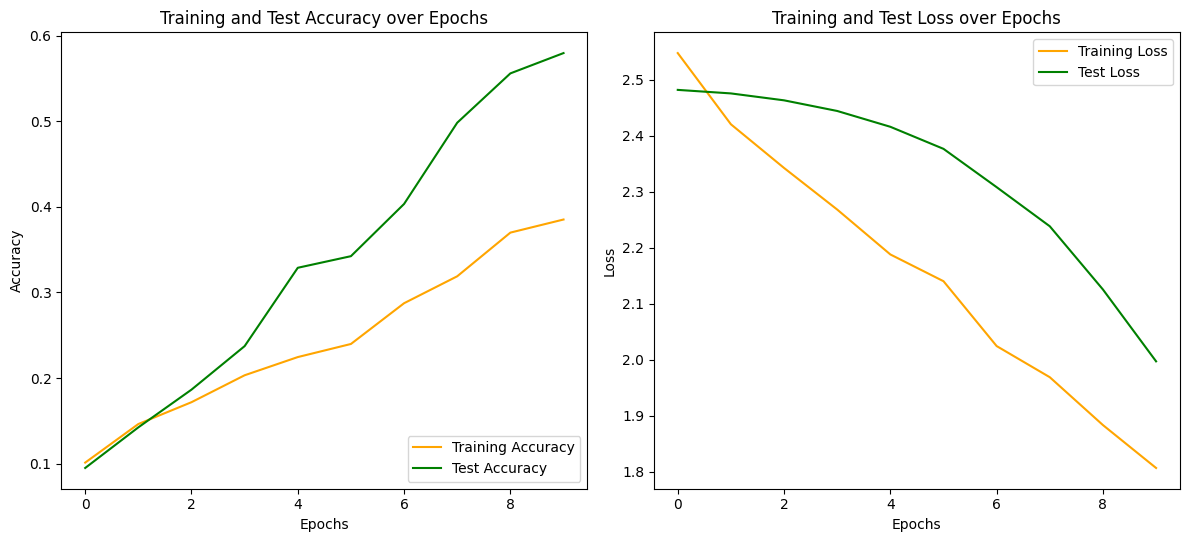

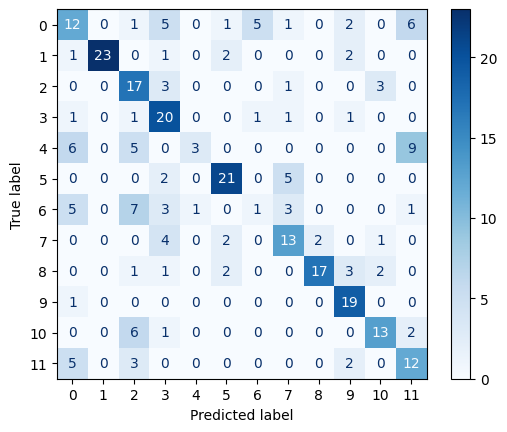

In [12]:
model_2.evaluate(X_test, y_test, X_train, y_train)

### 3. Third model - Double the Convolutional Neuron Size

From model 2 we concluded that increasing the layer count for our convolutional layers does not help our model. Now we want to see if increasing the neuron size helps our model. We will double the neuron size for our convolutional layers and see how the model performs.

Changes made compared to the initial model:

- `conv neuron size`: from 8 to 16

In [13]:
convolutional_layers_3 = [
    {'filter_size': 16, 'kernel': (3,3), 'activation': 'relu', 'max_pooling_2d_pool': (2,2), 'max_pooling_2d_strides': None, 'max_pooling_2d_padding': 'valid'},
    {'filter_size': 16, 'kernel': (3,3), 'activation': 'relu', 'max_pooling_2d_pool': (2,2), 'max_pooling_2d_strides': None, 'max_pooling_2d_padding': 'valid'},
]

layers_3 = [
    {'activation': 'relu', 'size': 16, 'use_bias': True, 'dropout': 0.5, 'batch_norm': True},
]

model_3 = NeuralNetwork(layers_3, convolutional_layers_3, 'model_3')

In [14]:
model_3.fit(X_train, y_train, X_test, y_test, epochs=10, early_stopping_patience=2, verbose=1)

Training model_3...
Epoch 1/10
37/37 [==============================] - 1s 28ms/step - loss: 2.3188 - accuracy: 0.1650 - val_loss: 2.2900 - val_accuracy: 0.0915
Epoch 2/10
37/37 [==============================] - 1s 25ms/step - loss: 2.0849 - accuracy: 0.2262 - val_loss: 2.1590 - val_accuracy: 0.3695
Epoch 3/10
37/37 [==============================] - 1s 25ms/step - loss: 2.0174 - accuracy: 0.2832 - val_loss: 2.0923 - val_accuracy: 0.4068
Epoch 4/10
37/37 [==============================] - 1s 26ms/step - loss: 1.9001 - accuracy: 0.3053 - val_loss: 2.0414 - val_accuracy: 0.4983
Epoch 5/10
37/37 [==============================] - 1s 25ms/step - loss: 1.8647 - accuracy: 0.3410 - val_loss: 1.9903 - val_accuracy: 0.4407
Epoch 6/10
37/37 [==============================] - 1s 25ms/step - loss: 1.8095 - accuracy: 0.3410 - val_loss: 1.9875 - val_accuracy: 0.3661
Epoch 7/10
37/37 [==============================] - 1s 26ms/step - loss: 1.7489 - accuracy: 0.4031 - val_loss: 1.9327 - val_accuracy: 

#### Evaluation

Compared to the first model, we still got worse results. However, this time the accuracy difference between training and testing is larger. We can also see this in the graphs. The accuracy over epochs for testing fluctuates a lot more. Our model is less stable now.

In the confusion matrix, we can see again something similar we have see before. A lot of labels get a false positive for labels 0 and 1.

Test Loss: 1.7220, Test Accuracy: 53.90%
Train Loss: 1.5394, Train Accuracy: 68.96%


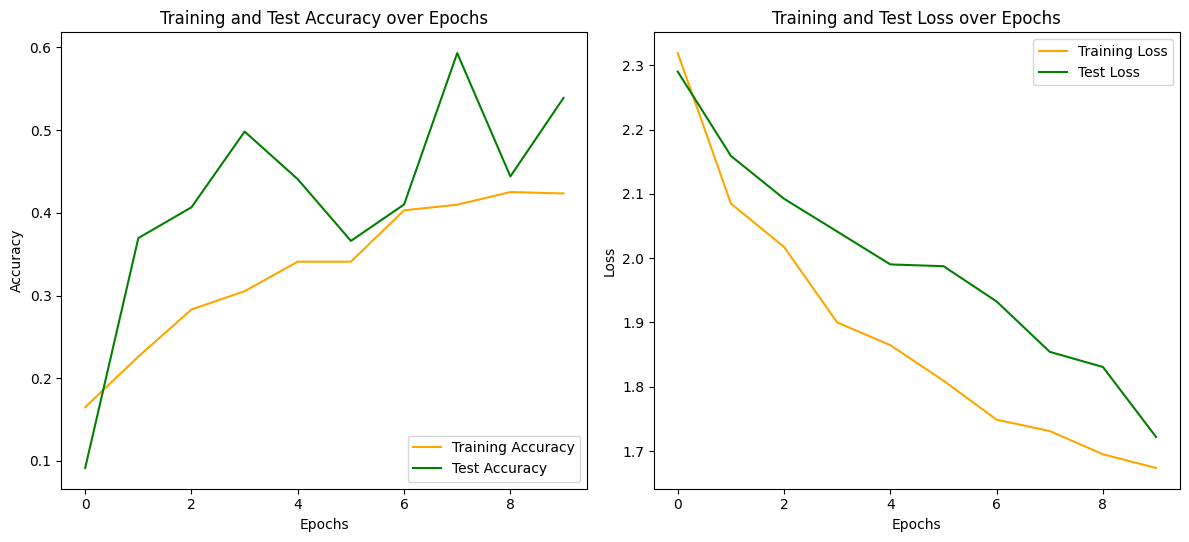

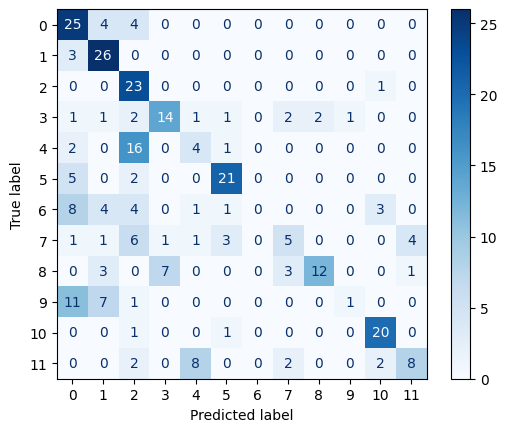

In [15]:
model_3.evaluate(X_test, y_test, X_train, y_train)

### 4. Forth model - Double Dense Layers

Before we experimented with different sizes and shapes for our convolutional layers. Now we want to see if increasing the size of our dense layers (but keeping the same conv layer) helps our model. We will double the neuron size for our dense layers and see how the model performs.

Changes made compared to the initial model:

- `dense layers`: from 1 to 2

In [16]:
convolutional_layers_4 = [
    {'filter_size': 8, 'kernel': (3,3), 'activation': 'relu', 'max_pooling_2d_pool': (2,2), 'max_pooling_2d_strides': None, 'max_pooling_2d_padding': 'valid'},
    {'filter_size': 8, 'kernel': (3,3), 'activation': 'relu', 'max_pooling_2d_pool': (2,2), 'max_pooling_2d_strides': None, 'max_pooling_2d_padding': 'valid'},
]

layers_4 = [
    {'activation': 'relu', 'size': 16, 'use_bias': True, 'dropout': 0.5, 'batch_norm': True},
    {'activation': 'relu', 'size': 16, 'use_bias': True, 'dropout': 0.5, 'batch_norm': True},
]

model_4 = NeuralNetwork(layers_4, convolutional_layers_4, 'model_4')

In [17]:
model_4.fit(X_train, y_train, X_test, y_test, epochs=10, early_stopping_patience=2, verbose=1)

Training model_4...
Epoch 1/10
37/37 [==============================] - 1s 24ms/step - loss: 2.9423 - accuracy: 0.1207 - val_loss: 3.2254 - val_accuracy: 0.1085
Epoch 2/10
37/37 [==============================] - 1s 20ms/step - loss: 2.5012 - accuracy: 0.1879 - val_loss: 2.5438 - val_accuracy: 0.2068
Epoch 3/10
37/37 [==============================] - 1s 20ms/step - loss: 2.3515 - accuracy: 0.2075 - val_loss: 2.0660 - val_accuracy: 0.3797
Epoch 4/10
37/37 [==============================] - 1s 20ms/step - loss: 2.2713 - accuracy: 0.2338 - val_loss: 2.1711 - val_accuracy: 0.2441
Epoch 5/10
37/37 [==============================] - 1s 21ms/step - loss: 2.0873 - accuracy: 0.2815 - val_loss: 2.1482 - val_accuracy: 0.2305
Epoch 6/10
37/37 [==============================] - 1s 21ms/step - loss: 2.0638 - accuracy: 0.2798 - val_loss: 1.8909 - val_accuracy: 0.3966
Epoch 7/10
37/37 [==============================] - 1s 20ms/step - loss: 1.9963 - accuracy: 0.3104 - val_loss: 1.9045 - val_accuracy: 

#### Evaluation

We can see basically the same results as with the previous, third model. We see a lot of fluctuation in the accuracy over epochs for testing, so our model is not stable. This is likely our big, 50% dropout. We use this big dropout to prevent overfitting, but it could make our model less stable.

Test Loss: 1.6876, Test Accuracy: 52.20%
Train Loss: 1.5629, Train Accuracy: 68.20%


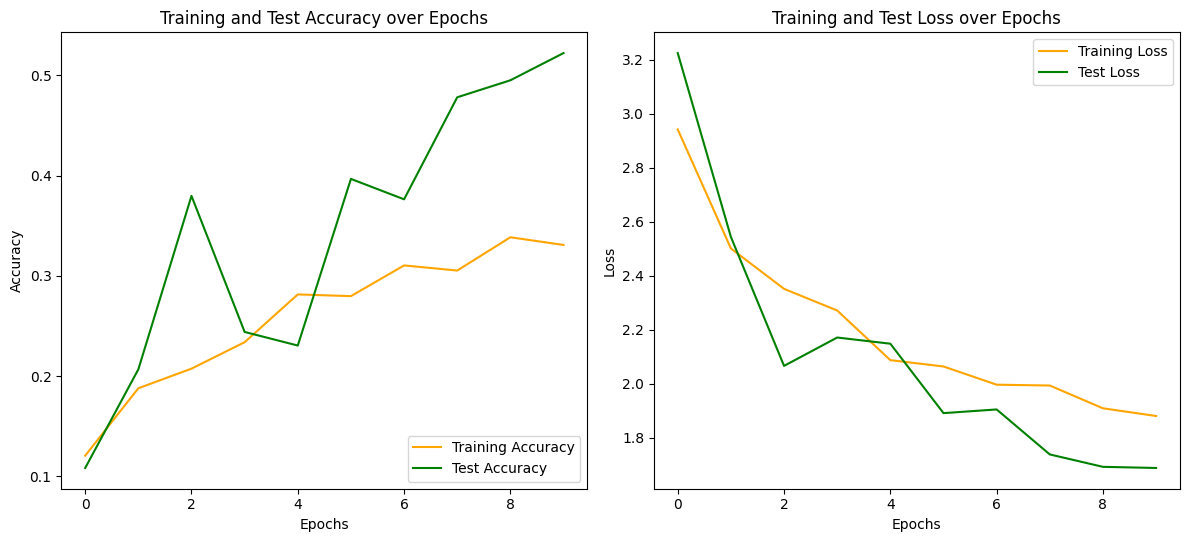

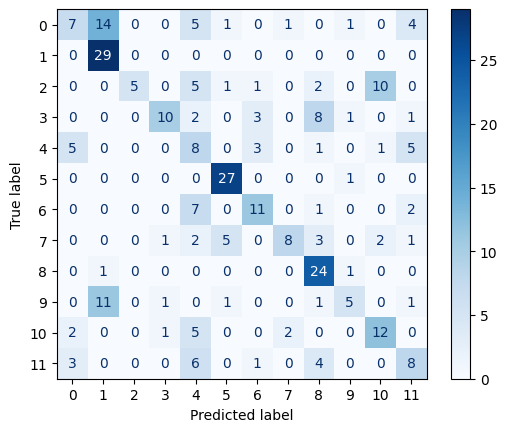

In [18]:
model_4.evaluate(X_test, y_test, X_train, y_train)

### 5. Fifth model - No Overfitting Prevention

In our previous models we always used overfitting prevention. We had a massive dropout of 50% and other techniques too. We saw that changing the sizes of the network did not help much. We thought this could be due to overfitting prevention, and this could be too aggressive. We will now try to remove all overfitting prevention and see how our model performs.

Changes made compared to the initial model:

- `dropout`: None
- `batch normalization`: False
- `bias`: False

In [19]:
convolutional_layers_5 = [
    {'filter_size': 8, 'kernel': (3,3), 'activation': 'relu', 'max_pooling_2d_pool': (2,2), 'max_pooling_2d_strides': None, 'max_pooling_2d_padding': 'valid'},
    {'filter_size': 8, 'kernel': (3,3), 'activation': 'relu', 'max_pooling_2d_pool': (2,2), 'max_pooling_2d_strides': None, 'max_pooling_2d_padding': 'valid'},
]

layers_5 = [
    {'activation': 'relu', 'size': 16, 'use_bias': False},
]

model_5 = NeuralNetwork(layers_5, convolutional_layers_5, 'model_5')

In [20]:
model_5.fit(X_train, y_train, X_test, y_test, epochs=10, early_stopping_patience=2, verbose=1)

Training model_5...
Epoch 1/10
37/37 [==============================] - 1s 23ms/step - loss: 2.3628 - accuracy: 0.1607 - val_loss: 2.1912 - val_accuracy: 0.2712
Epoch 2/10
37/37 [==============================] - 1s 20ms/step - loss: 1.8967 - accuracy: 0.3971 - val_loss: 1.7855 - val_accuracy: 0.4678
Epoch 3/10
37/37 [==============================] - 1s 20ms/step - loss: 1.4335 - accuracy: 0.5587 - val_loss: 1.4297 - val_accuracy: 0.5729
Epoch 4/10
37/37 [==============================] - 1s 20ms/step - loss: 1.0759 - accuracy: 0.6599 - val_loss: 1.2011 - val_accuracy: 0.6271
Epoch 5/10
37/37 [==============================] - 1s 21ms/step - loss: 0.8569 - accuracy: 0.7168 - val_loss: 1.0571 - val_accuracy: 0.6508
Epoch 6/10
37/37 [==============================] - 1s 21ms/step - loss: 0.6805 - accuracy: 0.7832 - val_loss: 0.9818 - val_accuracy: 0.7153
Epoch 7/10
37/37 [==============================] - 1s 20ms/step - loss: 0.5599 - accuracy: 0.8308 - val_loss: 0.9123 - val_accuracy: 

#### Evaluation

We can see a massive increase on both training and testing accuracies. We got almost 100% accuracy on training and 75% accuracy on testing. We can also observe a way smoother line over epochs for both training and testing on accuracy and loss. This indicates that our model is more stable.

Our confusion matrix also shows that less labels got misclassified. We can see that we have a lot of true positives.

**However**: We can see a massive increase in percentage difference for accuracy between training and testing. From about 9% (with overfitting prevention) to 15% (without overfitting prevention). This shows and proves that without these techniques, our model overfits more.

Test Loss: 0.7963, Test Accuracy: 76.95%
Train Loss: 0.2721, Train Accuracy: 93.96%


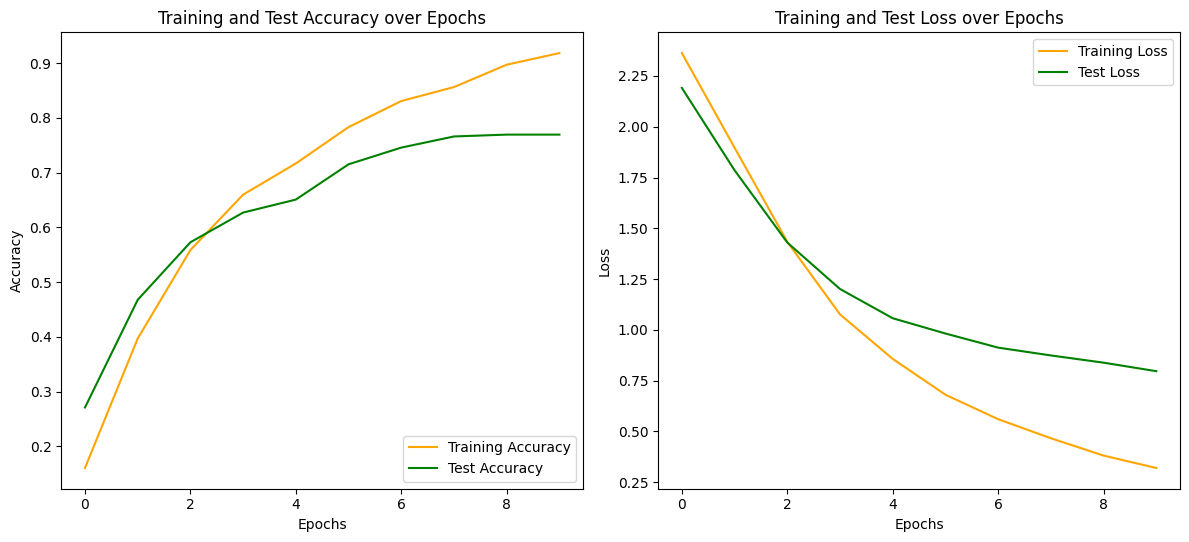

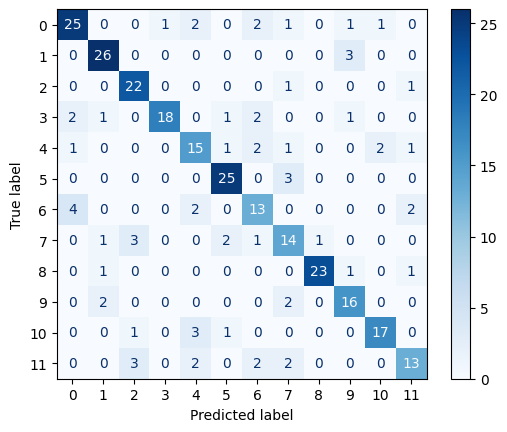

In [21]:
model_5.evaluate(X_test, y_test, X_train, y_train)

### 6. Sixth model - No Image Preprocessing

Now we want to see if our image preprocessing helps our model. We will disable all image preprocessing and see how our model performs.

Changes made compared to the initial model:

- `image preprocessing`: False

In [22]:
convolutional_layers_6 = [
    {'filter_size': 8, 'kernel': (3,3), 'activation': 'relu', 'max_pooling_2d_pool': (2,2), 'max_pooling_2d_strides': None, 'max_pooling_2d_padding': 'valid'},
    {'filter_size': 8, 'kernel': (3,3), 'activation': 'relu', 'max_pooling_2d_pool': (2,2), 'max_pooling_2d_strides': None, 'max_pooling_2d_padding': 'valid'},
]

layers_6 = [
    {'activation': 'relu', 'size': 16, 'use_bias': True, 'dropout': 0.5, 'batch_norm': True},
]

model_6 = NeuralNetwork(layer_config=layers_6, convolutional_layers=convolutional_layers_6, image_preprocessing=False, name='model_6')

In [23]:
model_6.fit(X_train, y_train, X_test, y_test, epochs=10, early_stopping_patience=2, verbose=1)

Training model_6...
Epoch 1/10
37/37 [==============================] - 1s 27ms/step - loss: 2.2627 - accuracy: 0.2500 - val_loss: 10.4925 - val_accuracy: 0.1356
Epoch 2/10
37/37 [==============================] - 1s 26ms/step - loss: 1.9426 - accuracy: 0.3503 - val_loss: 2.5655 - val_accuracy: 0.1661
Epoch 3/10
37/37 [==============================] - 1s 26ms/step - loss: 1.8111 - accuracy: 0.4022 - val_loss: 1.7981 - val_accuracy: 0.4068
Epoch 4/10
37/37 [==============================] - 1s 25ms/step - loss: 1.7279 - accuracy: 0.4107 - val_loss: 1.6656 - val_accuracy: 0.5051
Epoch 5/10
37/37 [==============================] - 1s 24ms/step - loss: 1.6138 - accuracy: 0.4643 - val_loss: 1.7762 - val_accuracy: 0.4475
Epoch 6/10
37/37 [==============================] - 1s 24ms/step - loss: 1.5497 - accuracy: 0.4923 - val_loss: 1.7019 - val_accuracy: 0.6271
Epoch 7/10
37/37 [==============================] - 1s 26ms/step - loss: 1.4819 - accuracy: 0.5077 - val_loss: 1.7742 - val_accuracy:

#### Evaluation

Without image preprocessing we can see an increase in accuracy for both training and testing when compared to our initial mode. Training got a massive accuracy increase, while testing got a small accuracy increase. We can see that our loss flattens after epoch 2 already for testing. For training the loss basically stays the same as it decreases very slowly.

Overall, our model is now giving us higher accuracies. However! The accuracy difference between training and testing is now way larger. This means that we have now a way larger overfitting. This is also proven by the higher fluctuation in accuracy over epochs for testing and the flattening for loss. This is likely because with image preprocessing we loose some data, so we get less accuracy, but our model is more stable. Now we get more data, so our model is more accurate but overfits more.

Test Loss: 1.4835, Test Accuracy: 67.80%
Train Loss: 1.1589, Train Accuracy: 87.33%


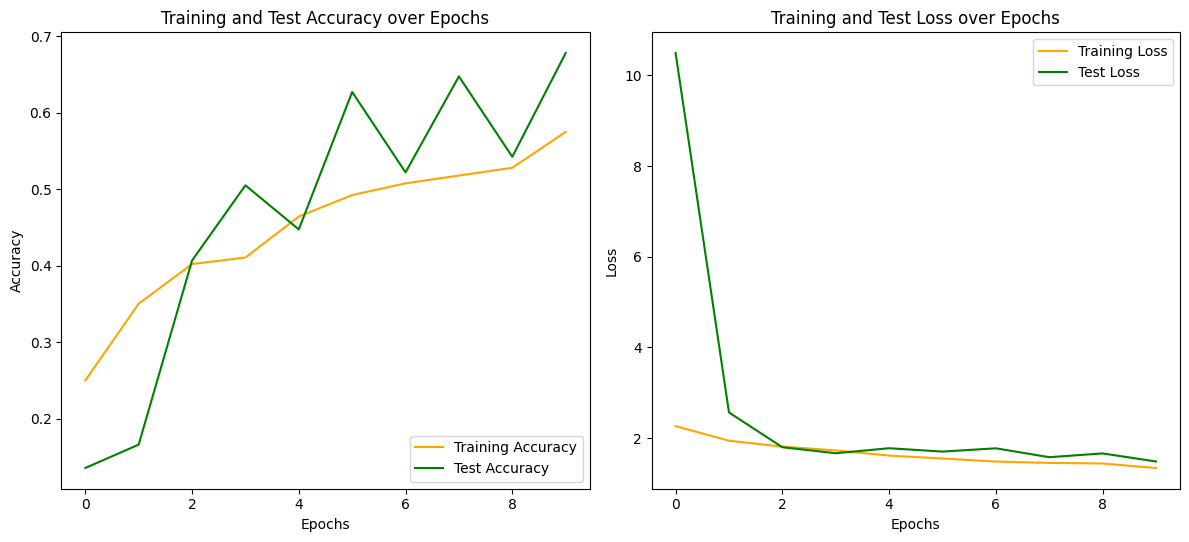

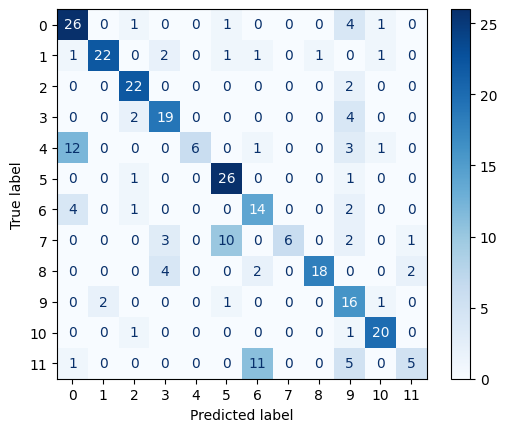

In [24]:
model_6.evaluate(X_test, y_test, X_train, y_train)

### 7. Seventh model - No pooling

This time we want to see what happens if we remove pooling. We will disable pooling and see how our model performs.

Changes made compared to the initial model:

- `pooling`: False

In [25]:
convolutional_layers_7 = [
    {'filter_size': 8, 'kernel': (3,3), 'activation': 'relu'},
    {'filter_size': 8, 'kernel': (3,3), 'activation': 'relu'},
]

layers_7 = [
    {'activation': 'relu', 'size': 16, 'use_bias': True, 'dropout': 0.5, 'batch_norm': True},
]

model_7 = NeuralNetwork(layers_7, convolutional_layers_7, 'model_7')

In [26]:
model_7.fit(X_train, y_train, X_test, y_test, epochs=10, early_stopping_patience=2, verbose=1)

Training model_7...
Epoch 1/10
37/37 [==============================] - 2s 45ms/step - loss: 2.3882 - accuracy: 0.1939 - val_loss: 5.0148 - val_accuracy: 0.1424
Epoch 2/10
37/37 [==============================] - 1s 40ms/step - loss: 2.0234 - accuracy: 0.2993 - val_loss: 2.6649 - val_accuracy: 0.1627
Epoch 3/10
37/37 [==============================] - 1s 40ms/step - loss: 1.8527 - accuracy: 0.3844 - val_loss: 2.3436 - val_accuracy: 0.1966
Epoch 4/10
37/37 [==============================] - 1s 40ms/step - loss: 1.7188 - accuracy: 0.4464 - val_loss: 2.0602 - val_accuracy: 0.3932
Epoch 5/10
37/37 [==============================] - 2s 42ms/step - loss: 1.6283 - accuracy: 0.4787 - val_loss: 1.9156 - val_accuracy: 0.5322
Epoch 6/10
37/37 [==============================] - 2s 42ms/step - loss: 1.5618 - accuracy: 0.4932 - val_loss: 1.8580 - val_accuracy: 0.5424
Epoch 7/10
37/37 [==============================] - 1s 40ms/step - loss: 1.4839 - accuracy: 0.5289 - val_loss: 1.8781 - val_accuracy: 

#### Evaluation

Now we can see a massive accuracy increase for our training set. This is ou highest so far. However, our testing accuracy barely increased. This is a clear sign of overfitting. Without pooling our model overfits more. Seeing that massive accuracy drop between epochs 6 and 8 for testing also shows that our model now is not stable anymore.

Without pooling, we likely have way more data for our model and now it overfits. With pooling, we reduce the amount of data, so our model is more stable, and thus overfits less (even if it costs us some accuracy).

Test Loss: 1.6775, Test Accuracy: 62.71%
Train Loss: 1.1161, Train Accuracy: 97.02%


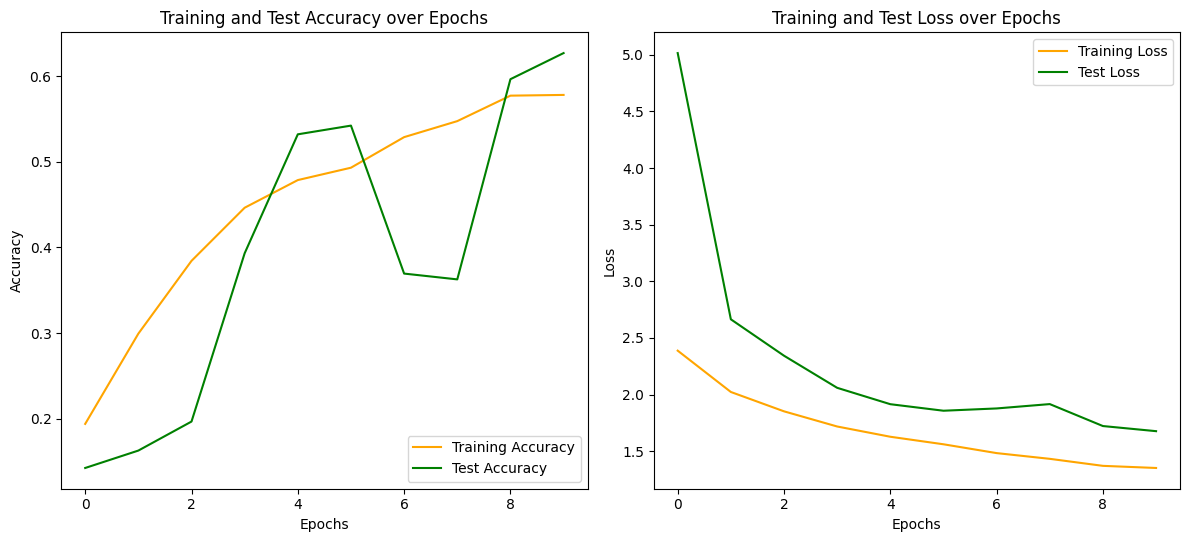

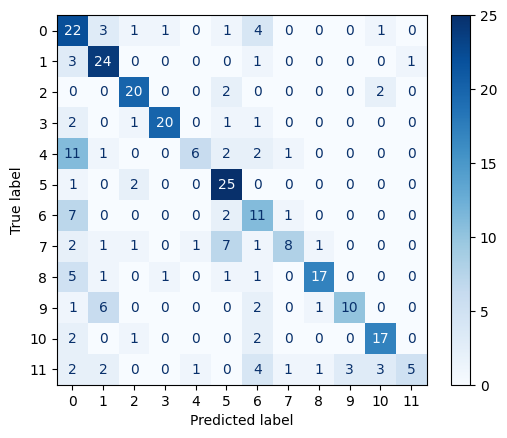

In [27]:
model_7.evaluate(X_test, y_test, X_train, y_train)

### 8. Eights model - Data Augmentation

When tackling a machine learning task involving images, it's essential not only to gather a set of images for training data but also to utilize augmentation techniques to introduce variations within the images. ([article](https://machinelearningmastery.com/image-augmentation-with-keras-preprocessing-layers-and-tf-image/) by Jason Brownlee). In general, image augmentation helps us to make smaller variations to our data which can help throughout epochs.

Keras offers many image augmentation techniques:

- Random crop
- Random flip
- Random translation
- Random rotation
- Random zoom
- Random contrast
- Random Brightness

The options brightness, contrast and translation are not applicable, as we work with black and white hand-drawn images. We believe, zooming and cropping are a bad idea as we might loose too much data (as we also concluded with our image preprocessing), since our drawn runes can be placed anywhere with any size. We cannot do flipping, as flipping would deviate too much from the original rune. Thus, for our dataset, rotation is the best option.

When rotating, we should only rotate slightly, max 10 degrees, so we don't alter the image too much.

Keras expects factors for rotation. A factor is a fraction of 2pi.

Changes made compared to the initial model:

- `rotation`: 10 degrees (0.03 factor)

In [37]:
convolutional_layers_8 = [
    {'filter_size': 8, 'kernel': (3,3), 'activation': 'relu', 'max_pooling_2d_pool': (2,2), 'max_pooling_2d_strides': None, 'max_pooling_2d_padding': 'valid'},
    {'filter_size': 8, 'kernel': (3,3), 'activation': 'relu', 'max_pooling_2d_pool': (2,2), 'max_pooling_2d_strides': None, 'max_pooling_2d_padding': 'valid'},
]

layers_8 = [
    {'activation': 'relu', 'size': 16, 'use_bias': True, 'dropout': 0.5, 'batch_norm': True},
]

model_8 = NeuralNetwork(layer_config=layers_8, convolutional_layers=convolutional_layers_8, name='model_8', random_rotation=True)

In [38]:
model_8.fit(X_train, y_train, X_test, y_test, epochs=10, early_stopping_patience=2, verbose=1)

Training model_8...
Epoch 1/10
37/37 [==============================] - 1s 27ms/step - loss: 2.7417 - accuracy: 0.1310 - val_loss: 3.4562 - val_accuracy: 0.0746
Epoch 2/10
37/37 [==============================] - 1s 24ms/step - loss: 2.2003 - accuracy: 0.2423 - val_loss: 2.4841 - val_accuracy: 0.0949
Epoch 3/10
37/37 [==============================] - 1s 23ms/step - loss: 1.9378 - accuracy: 0.3401 - val_loss: 2.0696 - val_accuracy: 0.3898
Epoch 4/10
37/37 [==============================] - 1s 23ms/step - loss: 1.8255 - accuracy: 0.3835 - val_loss: 1.8710 - val_accuracy: 0.3763
Epoch 5/10
37/37 [==============================] - 1s 24ms/step - loss: 1.6570 - accuracy: 0.4490 - val_loss: 1.6598 - val_accuracy: 0.6169
Epoch 6/10
37/37 [==============================] - 1s 23ms/step - loss: 1.6040 - accuracy: 0.4762 - val_loss: 1.5051 - val_accuracy: 0.6780
Epoch 7/10
37/37 [==============================] - 1s 23ms/step - loss: 1.5365 - accuracy: 0.5034 - val_loss: 1.4156 - val_accuracy: 

#### Evaluation

With a slight rotation, we can see our accuracy increase compared to the base model. This means, that a small variation in our data by applying a tiny rotation help our model become more accurate. This is likely because the hand-drawn runes always have a slight variation. So when a model trains, it is more strict on the runes it gets trained on, and when it sees a new variation in testing, it fails. With rotation it knows that the shapes can be slightly different, so it can better generalize.

We can also see this improvement in the confusion matrix. Only label 4 gets a massive false positive to label 0.

Test Loss: 1.2553, Test Accuracy: 73.22%
Train Loss: 1.0798, Train Accuracy: 81.21%


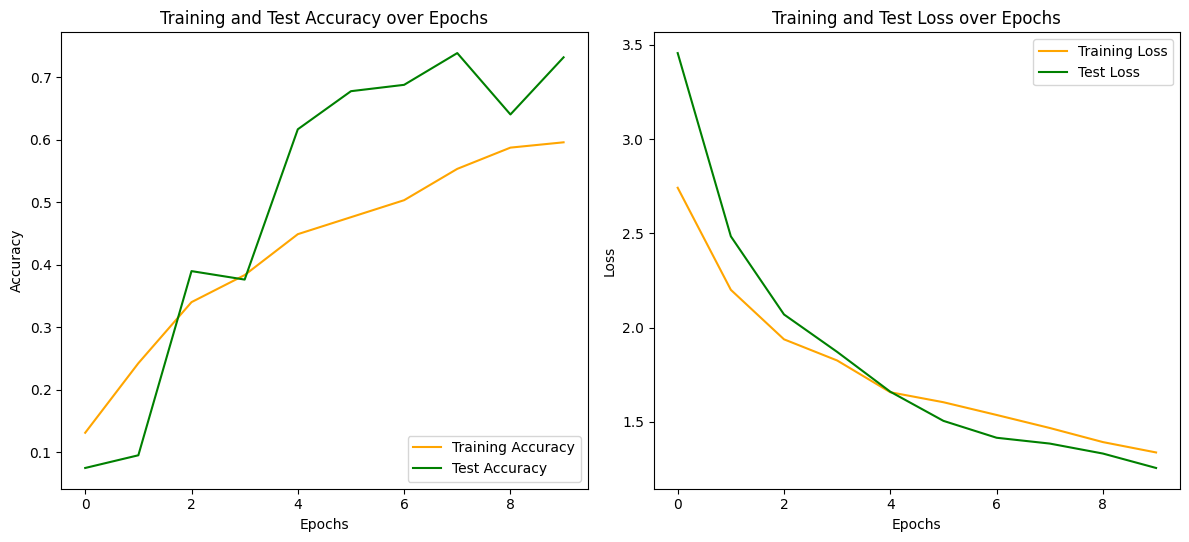

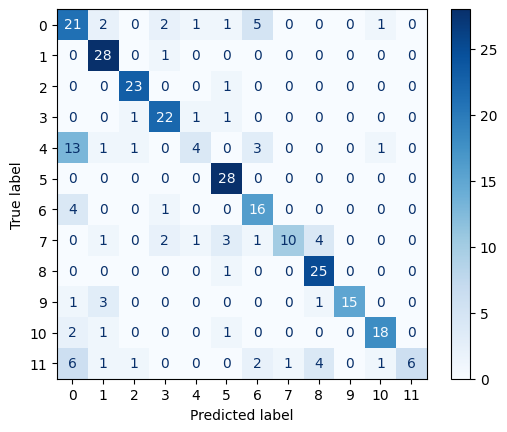

In [39]:
model_8.evaluate(X_test, y_test, X_train, y_train)

## Best model

When looking at our testing accuracies, 5th model had the highest accuracy on testing, meaning, this was our best model.

Given a folder with images with a naming convention of "`label`_`timestamp`.png", we can use our model to predict the labels of the images and display the accuracy.

**Important Note:** Due to the nature of the `get_dummies` function, all combinations of the rune types must be present. This means, that at least 12 unique rune images must be present. This is so that the `get_dummies` function can see all variations.

In [4]:
folder = 'test-runes' # test folder

# load keras model
best_model = tf.keras.models.load_model('./best-models/as2.2.keras')
# initialize predictor
predictor = NeuralNetwork(layer_config=None, convolutional_layers=None, name=None, model=best_model)
# predict with accuracy
predictor.predict(folder)

Test Loss: 0.3008, Test Accuracy: 91.67%
